# A/B test data

Dataset: https://www.kaggle.com/datasets/sergylog/ab-test-data

**[RU]**

Предположим, вы управляете интернет-магазином и хотите проверить, приведет ли новая версия страницы вашего продукта к увеличению дохода. У вас есть две версии страницы продукта: исходная версия (контрольная) и новая версия (вариант). Вы хотите проверить, какая версия приносит больший доход.

Сайт запустил A/B тест с целью увеличения дохода. Файл excel содержит необработанные данные о результатах эксперимента (user_id), типе выборки (variant_name) и доходе, принесенном пользователем (revenue).


**Задача — проанализировать результаты эксперимента и написать свои рекомендации.**
___________________________

**[ENG]**

Suppose you run an online store and you want to test whether a new version of your product page leads to increased revenue. You have two versions of the product page: the original version (control) and the new version (variant). You want to test which version leads to more revenue generation.

The site launched an A/B test in order to increase income. The excel file contains raw data on the results of the experiment (user_id), sample type (variant_name) and income brought by the user (revenue).


**The task is to analyze the results of the experiment and write your recommendations.**

# Defining Hypothesis

**Hypothesis #0:** *The new version of the product page (variant) will lead to more revenue than the original version (control)*

**Hypothesis #1:** *There is no statistically significant difference in revenue between the two versions of the product page*

# Split Traffic and Collect Data

**[RU]**

В данном случае мы уже имеем результаты проведения А/Б теста, поэтому такие шаги, как разделение трафика и сбор данных, я пропускаю

____________________

**[ENG]**

In this case, we already have the results of the A / B test, so I skip steps such as traffic splitting and data collection

# Loading & preprocessing data

## Load dataset

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

data = pd.read_csv('abtest_data.csv')

print('Data Shape:', data.shape)

data.head()

Data Shape: (10000, 3)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Renaming columns

In [115]:
data.columns = [col.lower() for col in data.columns]

## NaN Values in dataset

In [116]:
[print('Count of null in column [{}]: {}'.format(col, data[col].isnull().sum())) for col in data.columns];

Count of null in column [user_id]: 0
Count of null in column [variant_name]: 0
Count of null in column [revenue]: 0


**Conclusion:** There is no NaN values in dataset, which is perfect!

## Data Types

In [117]:
[print('Data types of column [{}]: {}'.format(col, data[col].dtype)) for col in data.columns];

Data types of column [user_id]: int64
Data types of column [variant_name]: object
Data types of column [revenue]: float64


**Conclusion:** Data types is also alright

## Outliers

First we must check if the clients that bring zero revenue in dataset

In [118]:
data['revenue'].apply(lambda x: 1 if x > 0 else 0).value_counts()

0    9848
1     152
Name: revenue, dtype: int64

We can see that there are only 152 values ​​greater than 0, so when we plot the box diagram, we only need to select them

In [119]:
fig = px.box(data[data['revenue'] > 0], y="revenue", height=400, width=400)
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
    yaxis=dict(
    title_text="Revenue"
    ),
    title_text='Revenue Boxplot',
    title_x=0.5
)
fig.show()

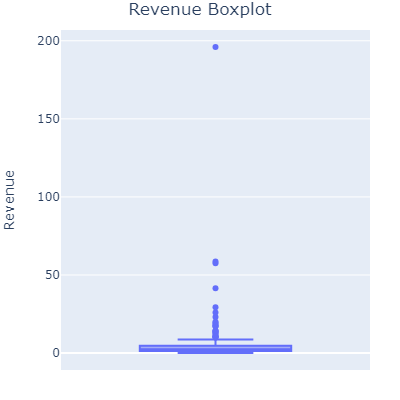

In [120]:
max_vals = data['revenue'].nlargest(2).values

print('Max Value of Revenue: {} - +{:.0f}%'.format(max_vals[0], max_vals[0]/max_vals[1]*100-100))
print('Last Max Value of Revenue Before Max: {}'.format(max_vals[1]))

del max_vals

Max Value of Revenue: 196.01 - +234%
Last Max Value of Revenue Before Max: 58.63


We can see that there is a one outlier, which value is 234% greater than the previous value. I think that we can drop it.

In [121]:
data = data[~data.index.isin(data['revenue'].nlargest(1).index)]

In [122]:
fig = px.box(data[data['revenue'] > 0], y="revenue", height=400, width=400)
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
#     paper_bgcolor="LightSteelBlue",
    yaxis=dict(
    title_text="Revenue"
    ),
    title_text='Revenue Boxplot',
    title_x=0.5
)
fig.show()

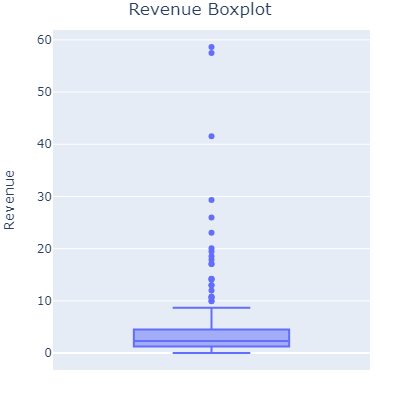

**Conclusion:** There was only one outlier that was 234% larger than the previous value, so we just excluded it

## Check samples

We have 2 groups of clients with various revenue: Control & Variant

In [123]:
print('Sample of control group: {} users'.format(len(data[data['variant_name'] == 'control'])))
print('Sample of variant group: {} users'.format(len(data[data['variant_name'] == 'variant'])))

Sample of control group: 4983 users
Sample of variant group: 5016 users


The control group contains fewer users than the test group. We need to make sure that the two groups have the same number of users

For this we will use random selection from numpy

In [124]:
min_sample_size = np.min([len(data[data['variant_name'] == 'control']), len(data[data['variant_name'] == 'variant'])])

#For control group
control_index = np.random.choice(data[data['variant_name'] == 'control'].index, size=min_sample_size, replace=False)

#For variantion group
variation_index = np.random.choice(data[data['variant_name'] == 'variant'].index, size=min_sample_size, replace=False)

users = data[data.index.isin(control_index) | data.index.isin(variation_index)].copy()

# EDA

## Revenue of the groups

In [125]:
revenue = users.pivot_table(index='variant_name', values='revenue', aggfunc='sum').reset_index()

fig = px.bar(revenue, x="variant_name", y="revenue", height=400, width=400, text_auto=True)
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
    yaxis=dict(
    title_text="Revenue"
    ),
    xaxis=dict(
    title_text="Group"
    ),
    title_text='Revenue of the groups',
    title_x=0.5
)
fig.show()

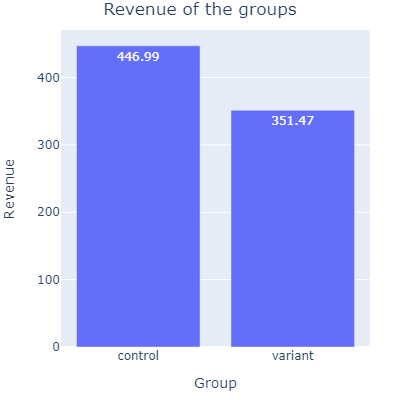

In [126]:
print('The control group brought in more income by {:.0f}%'.format(
    revenue.sort_values(by='revenue', ascending=False)['revenue'].values[0] /
    revenue.sort_values(by='revenue', ascending=False)['revenue'].values[1]
    * 100 - 100))

The control group brought in more income by 27%


**Conclusion:** The control group brought in more income by 27%

## ARPU - Average Revenue Per User

In [153]:
revenue_sum = users.pivot_table(index='variant_name', values='revenue', aggfunc='sum').values 
unq_user = users.pivot_table(index='variant_name', values='user_id', aggfunc='nunique').values

arpu = np.round(pd.DataFrame(revenue_sum / unq_user, columns=['Average Revenue Per User'], index=['control', 'variant']), 2)

fig = px.bar(arpu, x=arpu.index, y="Average Revenue Per User", height=400, width=400, text_auto=True)
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
    yaxis=dict(
    title_text="Average Revenue Per User"
    ),
    xaxis=dict(
    title_text="Group"
    ),
    title_text='ARPU of groups',
    title_x=0.5
)
fig.show()

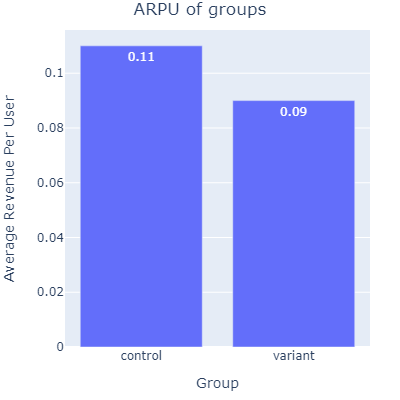

**Conclusion:** The control group has a higher ARPU than the test group.

# AOV - Average Order Value

In [154]:
aov = round(users.pivot_table(index='variant_name', values='revenue', aggfunc='mean'), 2).reset_index()
aov.columns = ['variant_name', 'Average Order Value']

fig = px.bar(aov, x='variant_name', y="Average Order Value", height=400, width=400, text_auto=True)
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
    yaxis=dict(
    title_text="Average Order Value"
    ),
    xaxis=dict(
    title_text="Group"
    ),
    title_text='AOV of groups',
    title_x=0.5
)
fig.show()

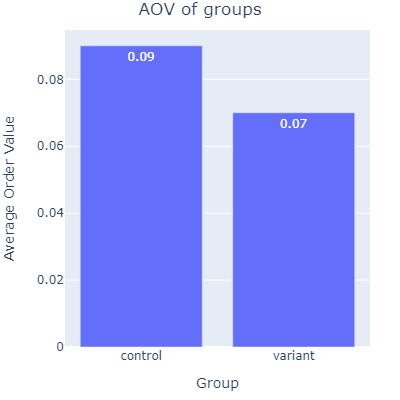

**Conclusion:** The control group has a higher AOV than the test group.

## Revenue Distribution

In [179]:
fig = px.histogram(users[users['revenue'] > 0], x='revenue', height=400, width=600, facet_col="variant_name",
                  color='variant_name')
fig.update_layout(
    margin=dict(l=30, r=30, t=50, b=30),
    yaxis=dict(
    title_text="Number of Users"
    ),
    title_text='Revenue Distribution',
    title_x=0.5,
    showlegend=False
)
fig.show()

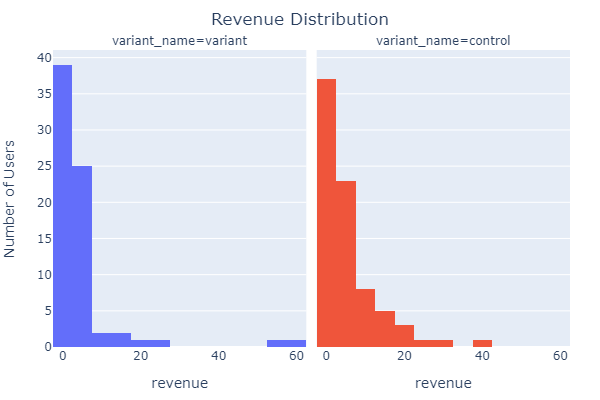

# Hypothesis Testing

**Hypothesis #0:** *The new version of the product page (variant) will lead to more revenue than the original version (control)*

**Hypothesis #1:** *There is no statistically significant difference in revenue between the two versions of the product page*

We will use T-test for the means of two independent samples of scores

If the p-value is less than 0.05, we can reject the null hypothesis and conclude that there is a statistically significant difference in revenue between the two versions of the product page. But we will see...

In [183]:
# import ttest_ind module to calculate t-test
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(users[users['variant_name'] == 'control']['revenue'],
                            users[users['variant_name'] == 'variant']['revenue'])

print("T-statistic: {:.3f}".format(t_stat))
print("P-value: {:.3f}".format(p_value))

T-statistic: 0.771
P-value: 0.441


**Conclusion:** P-value is greater than 0.05, so we do not have enough reason to reject the null hypothesis, and also to assert that the test group brought more income

# Conclusion

As shown by data analysis and hypothesis testing, we do not have enough reason to say that the test group brought more income than the control group. In this regard, most likely, you will either have to leave the original version of the site, or come up with new updates for the test.